# Lab 6

## Import Libraries

In [25]:
import pandas
import configparser
import psycopg2

In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## House Table

In [4]:
table_sql = """
            CREATE TABLE IF NOT EXISTS gp5.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """

In [5]:
cur.execute(table_sql)
conn.commit()

## Define Search Region

In [6]:
url = 'https://www.trulia.com/VA/Roanoke/24014/'

In [7]:
import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
# print(html_data.decode('utf-8'))

In [8]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)

## Insert Records into DB

In [19]:
for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp5.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass

## Query the Table

In [20]:
df = pandas.read_sql_query('select * from gp5.house ', conn)
df[:10]

,price,bed,bath,area,address
0,164950,3,1,1528,"716 Arbutus Ave SE, Roanoke, VA 24014"
1,299000,4,3,2557,"2315 Wycliffe Ave SW, Roanoke, VA 24014"
2,249500,4,3,2138,"1486 Craig Robertson Rd SE, Roanoke, VA 24014"
3,590000,5,5,3585,"2729 Rosalind Ave SW, Roanoke, VA 24014"
4,315000,3,3,2434,"3925 Three Chop Ln SW, Roanoke, VA 24014"
5,629000,5,4,3891,"2510 Avenham Ave SW, Roanoke, VA 24014"
6,309950,2,2,1721,"2208 S Jefferson St SW #208, Roanoke, VA 24014"
7,104950,2,1,1512,"2649 Garden City Blvd SE, Roanoke, VA 24014"
8,369000,4,3,2392,"3043 Hemlock Ln SW, Roanoke, VA 24014"
9,210000,3,2,1040,"2025 Woodland Rd SE, Roanoke, VA 24014"


## Basic Stat

In [22]:
df.describe()

,price,bed,bath,area
count,4.000000e+01,40.000000,40.000000,40.000000
mean,3.192234e+05,3.375000,2.900000,2658.400000
std,2.663714e+05,0.925078,1.645507,1660.920162
min,2.495000e+04,2.000000,1.000000,854.000000
25%,1.570500e+05,3.000000,1.000000,1508.000000
50%,2.324750e+05,3.000000,3.000000,2141.500000
75%,3.765000e+05,4.000000,4.250000,3973.250000
max,1.392400e+06,6.000000,7.000000,9278.000000


## Price Distribution

<AxesSubplot:>

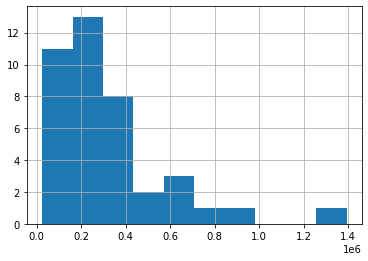

In [23]:
df['price'].hist()

## Bed vs Bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

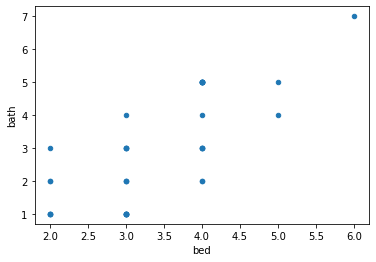

In [24]:
df.plot.scatter(x='bed',y='bath')